Minimum Distance obtained:  724.2231150461313
Performance over Simulated Annealing:  6.39%


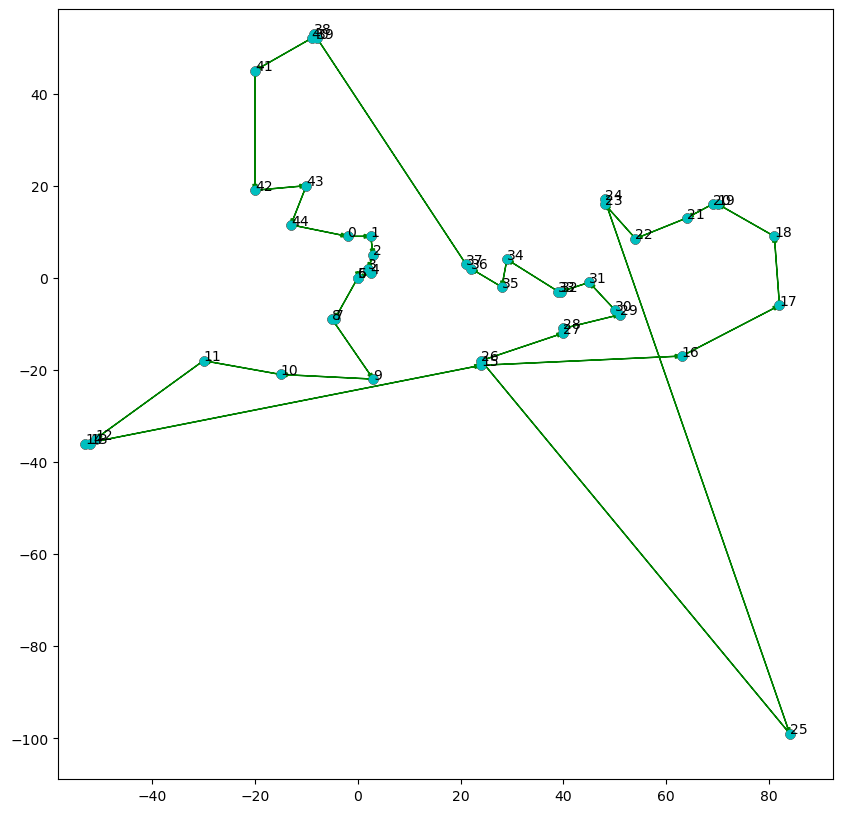

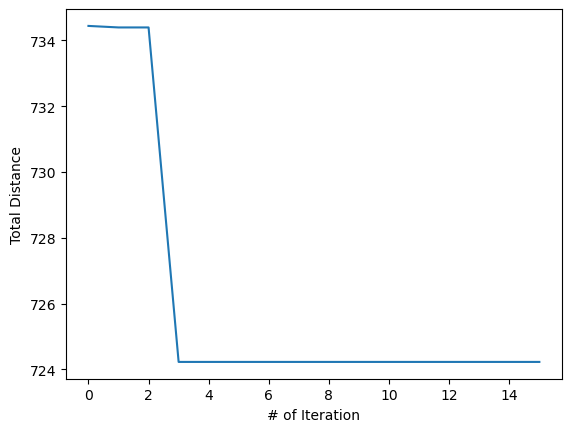

In [87]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
     
class SimulatedAnneling(object):
    def __init__(self,alpha=-1, stopping_T=-1, stopping_iter=-1):
        self.coords = self.getCity("City.txt")
        self.N = len(self.coords)
        self.templist=np.array(random.sample(range(1, int(math.sqrt( self.N)*1.5)), int(math.sqrt( self.N))))
        self.T = math.sqrt(self.N)
        self.T_save = self.T  # save inital T to reset if batch annealing is used
        self.alpha = np.round(np.random.uniform(0.5,1, int(math.sqrt( self.N))) ,3)
        self.stopping_temperature = 1e-8 if stopping_T == -1 else stopping_T
        self.improvement=5
        self.stopping_iter = 100000 if stopping_iter == -1 else stopping_iter
        self.iteration = 1

        self.nodes = [i for i in range(self.N)]

        self.best_solution = None
        self.best_fitness = float("Inf")
        self.fitness_list = []

        self.cur_fitness_replica=[]
        self.cur_solution_replica=[]
        
        self.best_fitness_replica=[]
        self.best_solution_replica=[]
        
    def plotReport(self,paths, points, num_iters=1):
        
        x = []; y = []
        for i in paths[0]:
            x.append(points[i][0])
            y.append(points[i][1])

        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'co')
        labels=list(range(0, len(x)))
        for i in range(len(x)):
            plt.scatter(x,y)
            plt.annotate(labels[i], (x[i], y[i]))

        a_scale = float(max(x))/float(100)

        if num_iters > 1:

            for i in range(1, num_iters):

                xi = []; yi = [];
                for j in paths[i]:
                    xi.append(points[j][0])
                    yi.append(points[j][1])

                plt.arrow(xi[-1], yi[-1], (xi[0] - xi[-1]), (yi[0] - yi[-1]),
                        head_width = a_scale, color = 'r',
                        length_includes_head = True, ls = 'dashed',
                        width = 0.001/float(num_iters))
                for i in range(0, len(x) - 1):
                    plt.arrow(xi[i], yi[i], (xi[i+1] - xi[i]), (yi[i+1] - yi[i]),
                            head_width = a_scale, color = 'r', length_includes_head = True,
                            ls = 'dashed', width = 0.001/float(num_iters))

        plt.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = a_scale,
                color ='g', length_includes_head=True)
        for i in range(0,len(x)-1):
            plt.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = a_scale,
                    color = 'g', length_includes_head = True)

        plt.xlim(min(x)*1.1, max(x)*1.1)
        plt.ylim(min(y)*1.1, max(y)*1.1)
        plt.show()
    
    def getCity(self,file):
        cityLocations = []
        with open(file, "r") as f:
            for cordination in f.readlines():
                cordination = [float(x.replace("\n", "")) for x in cordination.split(" ")]
                cityLocations.append(cordination)
        #print(coords)
        return cityLocations

    def initial_solution(self):
        cur_node = random.choice(self.nodes)  
        solution = [cur_node]

        free_nodes = set(self.nodes)
        free_nodes.remove(cur_node)
        while free_nodes:
            next_node = min(free_nodes, key=lambda x: self.Euclidean_dist(cur_node, x))  
            free_nodes.remove(next_node)
            solution.append(next_node)
            cur_node = next_node

        cur_fit = self.Total_dist(solution)
        if cur_fit < self.best_fitness: 
            self.best_fitness = cur_fit
            self.best_solution = solution
        self.fitness_list.append(cur_fit)
        
        self.cur_fitness_replica.append(self.best_fitness)
        self.cur_solution_replica.append(self.best_solution)
        
        return solution, cur_fit

    def Euclidean_dist(self, node_0, node_1):
        coord_0, coord_1 = self.coords[node_0], self.coords[node_1]
        return math.sqrt((coord_0[0] - coord_1[0]) ** 2 + (coord_0[1] - coord_1[1]) ** 2)

    def Total_dist(self, solution):
        cur_fit = 0
        for i in range(self.N):
            cur_fit += self.Euclidean_dist(solution[i % self.N], solution[(i + 1) % self.N])
        return cur_fit

    def copyReplica(self, candidate,T_instance):
        candidate_fitness = self.Total_dist(candidate)
        
        if candidate_fitness < self.cur_fitness:
            self.cur_fitness, self.cur_solution = candidate_fitness, candidate
            if candidate_fitness < self.best_fitness:
                self.best_fitness, self.best_solution = candidate_fitness, candidate
        else:
            if random.random() < math.exp(-abs(candidate_fitness - self.cur_fitness) / T_instance):
                self.cur_fitness, self.cur_solution = candidate_fitness, candidate
        
        if len(self.cur_fitness_replica)>0:
            best_replica=sorted(self.cur_fitness_replica, key = lambda x:float(x))[0]
            if best_replica < self.best_fitness:
                self.best_fitness, self.best_solution = best_replica, candidate_fitness
        else:
        
            self.best_fitness_replica.append(self.best_fitness)
            self.best_solution_replica.append(self.best_solution)
            self.cur_fitness_replica.append(self.cur_fitness)
            self.cur_solution_replica.append(self.cur_solution)

    def replica(self):
        
        print("cur_fitness_replica",self.cur_fitness_replica)
        print("cur_fitness_replica sorted", sorted(self.cur_fitness_replica, key = lambda x:float(x)))
        #print("cur_solution_replica",self.cur_solution_replica)
        print("Best_fitness_replica",self.best_fitness_replica.sort())
        #print("Bestr_solution_replica",self.best_solution_replica)
        
    def anneal(self):
        self.cur_solution, self.cur_fitness = self.initial_solution()
        temScheduler=0;
        for counter in range(len(np.array(self.templist))):
            
            while self.templist[counter] >= self.stopping_temperature and self.iteration < self.stopping_iter:
                
                temScheduler+=1
                candidate = list(self.cur_solution)
                l = random.randint(2, self.N - 1)
                i = random.randint(0, self.N - l)
                candidate[i : (i + l)] = reversed(candidate[i : (i + l)])
                self.copyReplica(candidate,self.templist[counter])
                self.templist[counter] *= self.alpha[counter]
                
                self.iteration += 1

                self.fitness_list.append(self.cur_fitness)
             
            if(temScheduler==10):
                    random.shuffle(self.templist)
                    random.shuffle(self.alpha)
        print("Minimum Distance obtained: ", self.best_fitness)
        self.improvement += 100 * (self.fitness_list[0] - self.best_fitness) / (self.fitness_list[0])
        print(f"Performance over Simulated Annealing: {self.improvement : .2f}%")

    def draw_paths(self):
        self.plotReport([self.best_solution], self.coords)

    def learning_progress(self):
        plt.plot([i for i in range(len(self.fitness_list))], self.fitness_list)
        plt.ylabel("Total Distance")
        plt.xlabel("# of Iteration")
        plt.show()



sa = SimulatedAnneling(stopping_iter=5000)
sa.anneal()
sa.draw_paths()
sa.learning_progress()